# [Titanic](https://www.kaggle.com/c/titanic/overview) 

* SVM -- 0.794
* PCA -- 0.799 (svm pca降9維度)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection # 分割資料模組
import sklearn.neighbors # 鄰進點模組
import sklearn.linear_model # 線性模組
import sklearn.svm # SVM 模組
import sklearn.naive_bayes # 貝氏分類模組
import sklearn.decomposition

%matplotlib inline

### 資料整理 & 展示

In [2]:
train = pd.read_csv('train.csv')
train_Survived = train[['PassengerId', 'Survived']]
train = train[['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']]
test = pd.read_csv('test.csv')
submission = pd.read_csv('gender_submission.csv')

In [3]:
train.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [5]:
train_Survived.head(3)

,PassengerId,Survived
0,1,0
1,2,1
2,3,1


In [6]:
submission.head(3)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


### 參數選用

|mark|參數|-|mark|參數|-|
|:---|:---|---:|:---|:---|---:|
|x|PassengerId|乘客編號|x|Survived|是否倖存|
|v|Pclass|     船票等級|x|Name    |乘客姓名|
|v|Sex|        乘客性別|v|Age        |年齡|
|o|SibSp|      堂兄弟妹|o|Parch |父母與小孩|
|x|Ticket|     船票號碼|o|Fare    |船票價格|
|o|Cabin|         船艙|o|Embarked|登入港口|

* marker:
    * v 選用
    * o 考參
    * x 不選用

* 選取參數 ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']

### 觀察數據 選用轉換`One-Hot encode`的參數 

* `Pclass`
* `Sex`
* `Cabin`
* `Embarked`

In [7]:
cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']
for col in cols:
    print(train[col].value_counts())

3    491
1    216
2    184
Name: Pclass, dtype: int64
male      577
female    314
Name: Sex, dtype: int64
24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64
8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
8.4583      1
9.8375      1
8.3625      1
14.1083     1
17.4000     1
Name: Fare, Length: 248, dtype: int64
G6             4
C23 C25 C27    4
B96 B98        4
F2             3
E101           3
              ..
C106           1
D21            1
E17            1
D10 D12        1
D46            1
Name: Cabin, Length: 147, dtype: int64
S    644
C    168
Q     77
Name: Embarked, dtype: int64


### 編碼前 先檢查空值`Nan`, 補上適合的值(補值的細節先放過)

* Age 補上平均值
* Cabin 空值多於, 放棄使用
* Embarked 補上最多的`'S'`

In [8]:
train.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
# 補上平均值
age_mean = train.Age.append(test.Age).mean()
fake_med = train.Fare.append(test.Fare).median()
train.Age = train.Age.fillna(age_mean)

# 補上最多值
train.Embarked = train.Embarked.fillna('S')

### 已經沒有空值

In [10]:
cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
train = train[cols]

train.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

### `Pclass`, `Sex`, `Embarked` 順利編碼

In [11]:
train.Pclass = train.Pclass.astype(np.str) # 艙等 int 修改為 string
train = pd.get_dummies(train)

In [12]:
train.head(3)

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,26.0,0,0,7.9250,0,0,1,1,0,0,0,1


### test data 依樣畫葫蘆 補上空值

In [13]:
test = test[cols]
test.isnull().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

In [14]:
test.Age = test.Age.fillna(age_mean)
test.Fare = test.Fare.fillna(fake_med)

In [15]:
test = test[cols]
test.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [16]:
test.Pclass = test.Pclass.astype(np.str)
test = pd.get_dummies(test)

In [17]:
test = test[train.columns]
test.head(3)

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,34.5,0,0,7.8292,0,0,1,0,1,0,1,0
1,47.0,1,0,7.0000,0,0,1,1,0,0,0,1
2,62.0,0,0,9.6875,0,1,0,0,1,0,1,0


### 將`['Age', 'SibSp', 'Parch', 'Fare']` 做正規化

In [18]:
val = train[['Age', 'SibSp', 'Parch', 'Fare']].values

model = sklearn.preprocessing.StandardScaler().fit(val) # 表現比較好
# model = sklearn.preprocessing.MinMaxScaler().fit(val)
train[['Age', 'SibSp', 'Parch', 'Fare']] = model.transform(val)

In [19]:
val = test[['Age', 'SibSp', 'Parch', 'Fare']].values
test[['Age', 'SibSp', 'Parch', 'Fare']] = model.transform(val)

In [20]:
X = train.values
y = train_Survived.Survived.values
submit_test = test.values # 輸出資料 預測X

In [21]:
X.shape

(891, 12)

In [22]:
submit_test.shape

(418, 12)

### PCA 視覺化 觀察是否容易分類

In [23]:
X.shape[1]

12

9


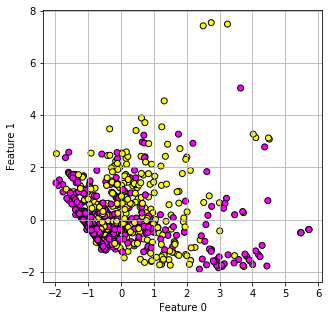

In [24]:
pca = sklearn.decomposition.PCA(n_components=9)
X = pca.fit_transform(X)

fig = plt.figure(figsize=(5, 5))
ax = plt.gca()
ax.scatter(X[:, 0], X[:, 1], c=y, ec='k', cmap=matplotlib.cm.spring)
ax.grid(True)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

print(X.shape[1])

In [25]:
pca.explained_variance_ratio_

array([0.3044556 , 0.23271583, 0.13206464, 0.10922459, 0.07408886,
       0.0614179 , 0.04372794, 0.02528591, 0.01701873])

### PCA降維度 & 資料分隔 
* 訓練資料
* 驗證資料

In [26]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.25, random_state=47)

### KNN

### Logistic Regression

### Naive Bayes Classifiers

### SVM Linear

### SVM rbf

In [27]:
svm = sklearn.svm.SVC(gamma='auto')
svm.fit(X_train, y_train)
train_s = svm.score(X_train, y_train)
test_s = svm.score(X_test, y_test)

print('train :', train_s)
print('test  :', test_s)

train : 0.8353293413173652
test  : 0.8385650224215246


### 選用SVM 用上全部資料訓練

In [28]:
svm = sklearn.svm.SVC(gamma='auto')
svm.fit(X, y)

print(svm.score(X, y ))

0.835016835016835


In [29]:
submission.Survived = svm.predict(pca.transform(submit_test))
submission.to_csv('submission.csv', index=0)